# Coding Discussion No. 5
## Name: Sahithi Adari
### Date: 11/08/20

In [2]:
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
from plotnine import *

# Silence warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as m

In [3]:
#Reading & renaming the CVS file and dropping the 'id' column
turnout = pd.read_csv("turnout.csv")
turnout = turnout.drop(['id'], axis = 1)

In [4]:
#Taking a random sample of 1600 rows and rearranging the columns
training = turnout.sample(n=1600).reset_index(drop = True)
training = training[['vote', 'white', 'age', 'educate', 'income']]

In [5]:
#Saving the remaining 400 rows and rearranging the columns
test = pd.concat([turnout,training]).drop_duplicates(keep=False).reset_index(drop = True)
test = test[['vote', 'white', 'age', 'educate', 'income']]

In this next section I decided to plot the 3 continuous variables (“educate”, “income”, and “age”) in order to determine their respective distributions.

(array([208., 304., 275., 194., 176., 170., 115.,  96.,  53.,   9.]),
 array([18. , 25.7, 33.4, 41.1, 48.8, 56.5, 64.2, 71.9, 79.6, 87.3, 95. ]),
 <BarContainer object of 10 artists>)

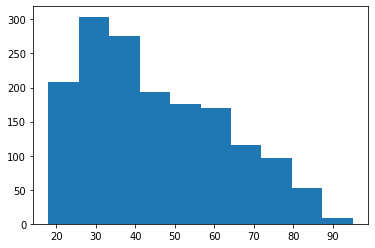

In [6]:
#Histogram of age
plt.hist(training.age)

(array([ 11.,  13.,  34.,  65., 179., 168., 643., 196., 207.,  84.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

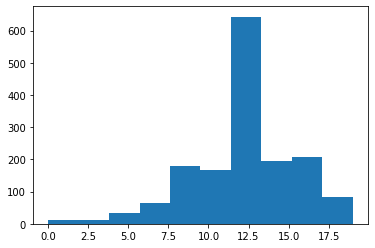

In [7]:
#Histogram of education
plt.hist(training.educate)

(array([338., 415., 332., 202., 128.,  96.,  22.,  45.,  14.,   8.]),
 array([ 0.     ,  1.49247,  2.98494,  4.47741,  5.96988,  7.46235,
         8.95482, 10.44729, 11.93976, 13.43223, 14.9247 ]),
 <BarContainer object of 10 artists>)

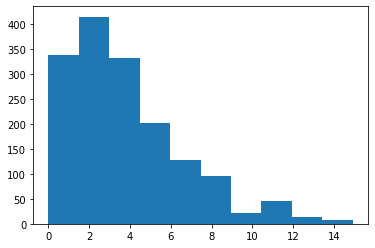

In [8]:
#Histogram of income
plt.hist(training.income)

Given that the continuous data is not normally distributed, I decided to categorize the 3 variables for easier analysis as it is easier to work with discrete data rather than a contineous one. 

The first thing I did was to create a new funtion that would modify our dataframe with continuous data into a dataframe with categorical data.

In [11]:
#Created a funtion that will take a dataset and categorize the continuous variables
def new_dta(data, outcome_var = "", exclude = ""):
    '''
    Takes a dataframe with binary and continuous variables and converts it into a dataframe with discrete values. The
    function does this by cutting the continuous data into 5 equally spaced bins, relabelling the old values with
    these new bin values (e.g. anyone with the age of 18 - 22 can be given the age value of 0 instead of
    their actual age), and saving these new columns onto a different dataframe.
    
    It also copies the binary columns as is to this new dataframe, and changes the datatype of the new categorial
    columns into 'int64'.

    Args:
        data (dataframe): the dataframe to be analyzed
        
        outcome_var (column title): a binary column to be excluded from categorizing
       
        exclude (column title): a binary column to be excluded from categorizing

    Returns:
        new (dataframe): dataframe with discrete values only
    '''
    new = pd.DataFrame()
    for v in data.columns: #Created a for loop to go through all the columns of the dataframe
        if v != exclude and v != outcome_var: #Excluded both binary columns
            new[v+"_bin"] = pd.cut(data[v], 5, labels = ["0", "1", "2", "3", "4"]) #Cut the continuous data into 5, equally, spaced bins
            new[v+"_bin"] = new[v+"_bin"].astype('int64') #Changed the datatype of these new columns
        else: 
            new[v] = data[v]
    return new

This second function would calculate the class and conditional probabilities of the new categorical dataframe.

In [13]:
#Created a function that would take a dataset and calculate the class and conditional probabilites of the dataset
def calc_probs(data, outcome_var = "", exclude = ""):
    '''
    Function calculates the class and conditional probabilities of the binary and categorial data by using a dictionary
    with tuple keys. It calculate the conditional probability, for the categorical data, by determining the probability
    of vote per the 5 categorical values. (I.e Pr(votes|age category = 0))
    
    Args:
    data (dataframe): the dataframe to be analyzed

    outcome_var (column title): a binary column to excluded from analysis as it is the outcome column

    exclude (column title): a binary column to excluded from categorizing

    Returns:
        edited (dataframe), class_probs (dictionary), cond_probs (dictionary): a dataframe of the categorized data,
        a dictionary of the class probabilites, and a dictionary of the conditional probabilites
    '''
    class_probs = {}
    cond_probs = {}
    edited = new_dta(data, outcome_var, exclude) #Passed the "new_dta" function
    column_names = [v for v in edited.columns if v != outcome_var] #Located all columns that are not the outcome
    for y, d in edited.groupby(outcome_var):
        class_probs.update({y: d.shape[0]/edited.shape[0]}) #Calculated the class probabilities
        for v in column_names: #Created a for loop to go down each column
            values = list(edited[v].unique()) #Created a list of the unique values in each column
            for x in values: #Created a for loop to calculate the probability of voting per unique column values
                pr = (d[d[v] == x].shape[0]) / (edited[edited[v] == x].shape[0])
                cond_probs[(v,x,y)] = pr #Saved the calculated probability into a dictionary
    return edited, class_probs, cond_probs

In [15]:
#Created a function that calculate a prediction of voting behavior based on the demographic variables
def predict(data, outcome_var = "", exclude = ""):
    '''
    Function calculates the conditional probability of whether they voted or not based on the demographic variables
    presented in the dataset. It then returns both the probabilities and the most likely situation (whether a person
    voted or not). 
    
    Args:
    data (dataframe): the dataframe to be analyzed

    outcome_var (column title): a binary column to excluded from analysis as it is the outcome column

    exclude (column title): a binary column to excluded from categorizing

    Returns:
        Dataframe: a dataframe 
    '''
    store_preds = [] #Created an empty list
    predict_dta, class_probs, cond_probs = calc_probs(data, outcome_var, exclude) #Passed the "calc_probs" function
    for i,row in predict_dta.iterrows():
        pr_1 = 1; pr_0 = 1
        for j in range(1,len(row.index)): #Calculated the conditional probability of each row
            pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
            pr_1 *= cond_probs[(row.index[j],row.values[j],1)]     
        pr_0 *= class_probs[0] 
        pr_1 *= class_probs[1]
        store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

In [18]:
#Results
preds = predict(training, outcome_var = "vote", exclude = "white")

In [19]:
#Accuracy of prediction
accuracy = sum(training.vote == preds.pred)/training.shape[0]
accuracy

0.740625

In [20]:
#Testing accuracy
test_preds = predict(test, outcome_var = "vote", exclude = "white")
test_accuracy = sum(test.vote == test_preds.pred)/test.shape[0]
test_accuracy

0.7666666666666667

In [21]:
#Organized the data in order to plug into the sklearn API easily
train_vote = training['vote']
train_other = training[['white', 'age', 'educate', 'income']]
test_vote = test['vote']
test_other = test[['white', 'age', 'educate', 'income']]

In [22]:
#Instantiate the model class
gnb = GaussianNB()
gnb.fit(train_other, train_vote) # Train

# Predict 
y_pred = gnb.predict(test_other)

# Out-of-sample performance 
m.accuracy_score(test_vote,y_pred)

0.7256410256410256

In [23]:
#Created a model to return probabilites not predictions
probs = gnb.predict_proba(test_other)
probs =  pd.DataFrame(probs,columns=gnb.classes_)
probs

,0,1
0,0.245118,0.754882
1,0.190520,0.809480
2,0.243826,0.756174
3,0.720039,0.279961
4,0.218539,0.781461
...,...,...
385,0.193426,0.806574
386,0.068611,0.931389
387,0.053458,0.946542
388,0.804886,0.195114


In [24]:
#Generated the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_vote, probs[1])

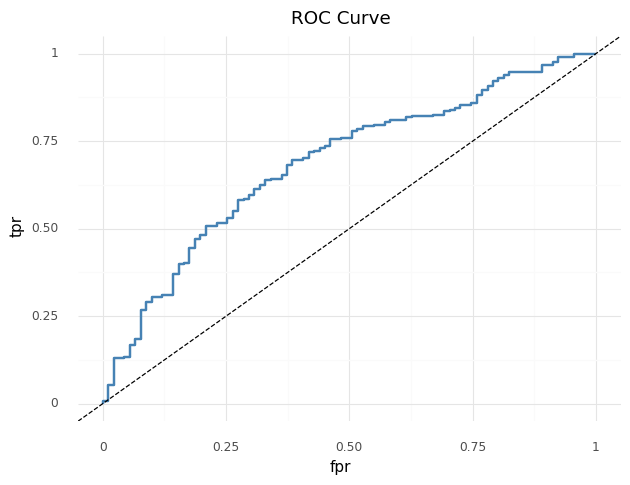

<ggplot: (307919879)>

In [25]:
#Plotted the ROC curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)